In [1]:
import torch
import pandas as pd
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

from torch import nn
from torch import optim

import torch.nn.functional as F
import scipy
from sklearn.utils import resample
from collections import OrderedDict

In [31]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, images_path):
        self.dataframe = dataframe
        self.images_path = images_path

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
#         print(row['index'])
        img = Image.open(self.images_path + str(int(row['index'])).zfill(4) + '.jpg')
#         img = img.resize((224,224), Image.ANTIALIAS)
        
        return (
            torchvision.transforms.functional.to_tensor(img),
            row["data"],
        )


In [23]:
df = pd.read_csv('train_steer.csv', index_col=False)
df = df.reset_index()


<AxesSubplot:ylabel='Frequency'>

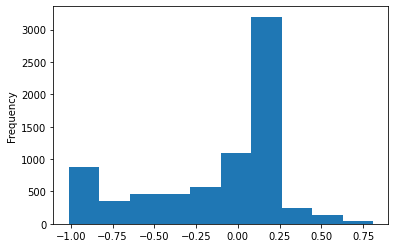

In [24]:
# image, label = next(iter(test_dataset))
df.data.plot.hist()

,index,Unnamed: 0,data
0,0,0,0.0875
1,1,1,0.0900
2,2,2,0.0900
3,3,3,0.0875
4,4,4,0.0875
...,...,...,...
1379,1379,1379,-0.9125
5606,5606,5606,-0.4525
2403,2403,2403,-0.6275
559,559,559,-0.9475


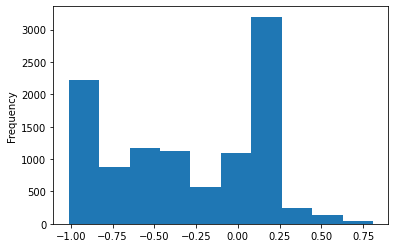

In [32]:
# plt.imshow(image.permute(1, 2, 0))
threshold = -0.3
df_min = df[df.data < threshold]
df_maj = df[df.data >= threshold]

df_minority_upsampled = resample(df_min, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_maj),    # to match majority class
                                 random_state=123)
# df
df_balanced = pd.concat([df_maj, df_minority_upsampled])
df_balanced.data.plot.hist()

df_balanced
# train_df['data'].plot.hist()

In [34]:
dataset = Dataset(df_balanced, '../catkin_ws/images/train_images/left')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)


In [35]:
import torchvision.models as models
model = models.resnet18(pretrained = True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [36]:
for param in model.parameters():
    param.requires_grad = False 

In [38]:
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,256)),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(256,128)),
    ('relu2', nn.ReLU()),
    ('fc3', nn.Linear(128,64)),
    ('relu3', nn.ReLU()),
    ('fc4', nn.Linear(64,1)),
    ('out', nn.Tanh())
])).to(device)

model.fc = fc

In [39]:
model = model.to(device);

image, l = next(iter(dataloader))

Epoch : 1/5.. Training Loss: 0.136584
Epoch : 2/5.. Training Loss: 0.116273
Epoch : 3/5.. Training Loss: 0.108339
Epoch : 4/5.. Training Loss: 0.100913
Epoch : 5/5.. Training Loss: 0.097724


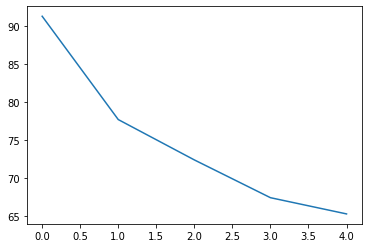

In [40]:
def train(model, trainloader, criterion, optimizer, epochs = 5):
    train_loss =[]
    for e in range(epochs):
        running_loss =0
        for images, labels in trainloader:
            inputs, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            out = model(inputs)
            target = labels.reshape(out.shape[0],1).float()
            loss = criterion(out, target)
            running_loss+=loss
            loss.backward()
            optimizer.step()
        print("Epoch : {}/{}..".format(e+1,epochs),
         "Training Loss: {:.6f}".format(running_loss/len(trainloader))) 
        train_loss.append(running_loss)
    plt.plot(train_loss,label="Training Loss")
    plt.show() 
    
    
    
epochs = 5
model.train()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.MSELoss()  
train(model,dataloader,criterion, optimizer, epochs)        

In [41]:
torch.save(model, "balanced_model")

tensor([[-0.3732],
        [ 0.1491],
        [ 0.1671],
        [-0.0122],
        [-0.1624],
        [-0.1104],
        [ 0.1240],
        [-0.3811],
        [-0.1778],
        [-0.1652],
        [ 0.0467],
        [ 0.0979],
        [-0.5751],
        [ 0.0948],
        [-0.4291],
        [ 0.1032]], device='cuda:0', grad_fn=<AddmmBackward>)

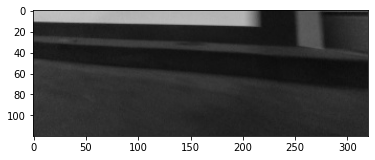

In [27]:
model.eval()
image, l = next(iter(dataloader))
img = image[0]
plt.imshow(img.permute(1, 2, 0))
model(image.to(device))